In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde


In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keep the original color scheme and style definitions
BLUE = '#003049'  # Color for negative sentiment
RED = '#d62828'   # Color for positive sentiment

# Define markers for different model types
MARKERS = {
    'ml': 'o',
    'dictionary': 'o'
}

# Define line styles for different model types
LINESTYLES = {
    'ml': 'dashed',
    'dictionary': 'solid'
}

# Customizable plot parameters
TITLE_SIZE = 28
LABEL_SIZE = 24
TICK_SIZE = 18
MARKER_ALPHA = 0.01
MARKER_SIZE = 150 
LEGEND_MARKER_SIZE = 10

def plot_bias(df):
    """
    Create only the Relative Bias plot (formerly the second subplot)
    """
    # Create a single figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot for Relative Bias (bias_1)
    plot_subplot(df, ax, 'bias_1', 'Men Bias (relative error rate increase)')
    
    # Create legend
    create_legend(ax)
    
    # Set x-axis label
    ax.set_xlabel('Women Error', fontsize=LABEL_SIZE)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

def plot_subplot(df, ax, bias_field, bias_label):
    """
    Plot scatter points and density contours for a specific bias field
    """
    # Get unique model types and sentiment levels
    model_types = df['model_type'].unique()
    sentiment_levels = ['positive', 'negative']
    
    # For each model_type and sentiment level combination, plot points and contours
    for model_type in model_types:
        marker = MARKERS.get(model_type, 'o')
        
        for level in sentiment_levels:
            # Filter data for this model_type and sentiment level
            data_subset = df[(df['model_type'] == model_type) & (df['level_value'] == level)]
            
            if len(data_subset) == 0:
                continue
            
            # Determine color based on sentiment
            color = BLUE if level == 'negative' else RED
            
            # Plot scatter points
            ax.scatter(data_subset['error_1'], data_subset[bias_field], 
                      color=color,
                      marker=marker,
                      s=MARKER_SIZE,
                      alpha=MARKER_ALPHA,
                      edgecolors='none')
            
            linestyle = LINESTYLES.get(model_type, 'solid')
                    
            # Plot KDE with 95% of data
            sns.kdeplot(
                x=data_subset['error_1'],
                y=data_subset[bias_field],
                levels=[0.05],
                color=color,
                ax=ax,
                alpha=0.5,
                linewidths=2,
                linestyles=linestyle,
                fill=False
            )
        
    # Add reference line (y=0, no bias)
    ax.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    
    # Setup axis labels
    #ax.set_ylabel(bias_label, fontsize=LABEL_SIZE)
    #ax.set_ylabel(r"Men Bias $\mathregular{\scriptsize{(relative\ error\ rate\ increase)}}$")

    ax.set_ylabel("")
    
    # Add the main label text
    ax.text(-0.30, 0.5, "Men Bias", 
            transform=ax.transAxes, 
            rotation=90, 
            verticalalignment='center', 
            fontsize=LABEL_SIZE)
    
    # Add the smaller text below
    ax.text(-0.21, 0.5, "relative error rate increase", 
            transform=ax.transAxes, 
            rotation=90, 
            verticalalignment='center', 
            fontsize=12)
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    
    # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits for x-axis
    ax.set_xlim(0, 0.6)
    ax.set_ylim(-0.25, 1.25)

def create_legend(ax):
    """
    Create a legend for the specified axes
    """    
    # Color legend elements
    color_legend_elements = [
        plt.Line2D([0], [0], marker='s', color=BLUE, label='Negative',
                  markerfacecolor=BLUE, markersize=LEGEND_MARKER_SIZE, linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=RED, label='Positive',
                  markerfacecolor=RED, markersize=LEGEND_MARKER_SIZE, linestyle='None')
    ]
    
    # Add contour elements to the legend for each model type and density level
    contour_legend_elements = [
        plt.Line2D([0], [0], color='#999', label='ML', linestyle='dashed'),
        plt.Line2D([0], [0], color='#999', label='Dictionary', linestyle='solid')
    ]
    
    # Add the legend to the axes
    ax.legend(handles=color_legend_elements + contour_legend_elements, 
              loc='upper right', frameon=False, fontsize=16)

In [173]:
all_rankings = []
for i in range(1, 1001):
    df = pd.read_csv(f'data/boot2/errors_{i}.csv')
    
    df = df[(df['level'] == 'sentiment') & (df['error_type'] == 'valence')]
    model_list = df['model'].unique()
    
    ranking = []
    
    for level in ['positive', 'negative']:
        for model in model_list:
            # Get the subset for this level_value and model
            subset = df[(df['level_value'] == level) & (df['model'] == model)]
            
            error_0 = subset[subset['sex'] == 0]['error_value'].values[0]
            error_1 = subset[subset['sex'] == 1]['error_value'].values[0]
                
            bias_1 = (error_0 - error_1) / error_1
            bias_2 = error_0 - error_1
            
            ranking.append({
                'level_value': level,
                'model': model,
                'model_type': subset[subset['sex'] == 0]['model_type'].values[0],
                'error_0': error_0,
                'error_1': error_1,
                'bias_1': bias_1,
                'bias_2': bias_2
            })
    
    ranking = pd.DataFrame(ranking)
    all_rankings.append(ranking)
    
rankings = pd.concat(all_rankings, ignore_index=True)

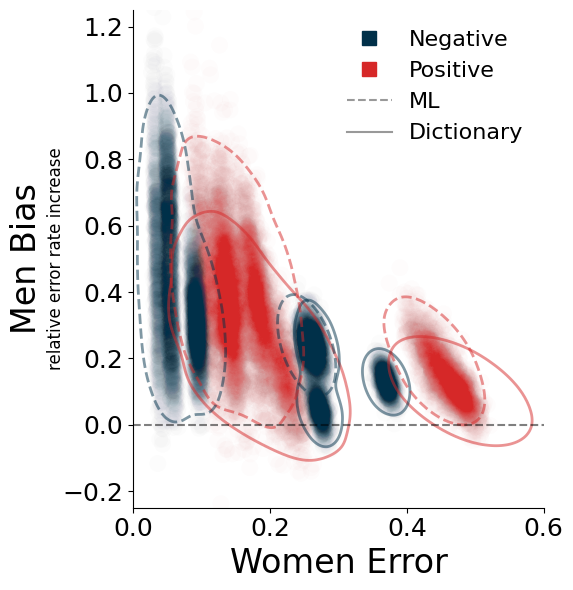

In [185]:
fig = plot_bias(rankings)
plt.savefig('ranking.png', dpi=600)
#plt.savefig('ranking_lowres.png', dpi=150)